# Global imports and data preprocessing

In [ ]:
df_fit_results['skewness_sq'] = df_fit_results['skewness'] ** 2 
df_fit_results["task_metric"] = df_fit_results["task"] + "_" + df_fit_results["metric"] 
df_fit_results = df_fit_results.reset_index(drop=True)
df_fit_results["task_metric"] = df_fit_results["task_metric"].astype(str)
df_fit_results = df_fit_results.dropna(subset=["beta2", "skewness_sq", "kurtosis", "task_metric"])

# --- Base model ---
model = smf.mixedlm("beta2 ~ skewness", df_fit_results, groups=df_fit_results["task_metric"])
fit = model.fit()

# --- Function to compute marginal R² ---
def compute_r2_marginal(fit, df):
    X_fixed = pd.DataFrame({
    "Intercept": 1.0,
    "skewness": df_fit_results["skewness"].astype(float)
    }, index=df_fit_results.index)
    mu_fixed = X_fixed.dot(fit.fe_params)            # fixed-effect linear predictor
    var_fixed = np.var(mu_fixed, ddof=1)             # σ_f^2

    # random intercept variance (if random intercept only)
    var_random = float(fit.cov_re.iloc[0, 0])        # σ^2_random

    # residual variance
    var_resid = float(fit.scale)                     # σ^2_resid

    # Marginal R2 and implied correlation (includes intercept variance)
    R2_marginal = var_fixed / (var_fixed + var_random + var_resid)
    return np.sign(fit.fe_params["skewness"]) * np.sqrt(R2_marginal)
# --- Observed R² ---
R2_marginal = compute_r2_marginal(fit, df_fit_results)
print(f"Observed R²_marginal = {R2_marginal:.4f}")

# -------------------
# Bootstrap CI (two-level)
# -------------------
n_boot = 9999
boot_r2 = []
groups = df_fit_results["task_metric"].unique()
rng = np.random.default_rng(seed=42)

for b in range(n_boot):
    print(b)
    # Step 1: sample groups with replacement
    sampled_groups = rng.choice(groups, size=len(groups), replace=True)
    boot_samples = []

    # Step 2: within each group, resample observations with replacement
    for g in sampled_groups:
        df_group = df_fit_results[df_fit_results["task_metric"] == g]
        df_group_boot = df_group.sample(n=len(df_group), replace=True, random_state=rng.integers(1e9))
        df_group_boot["task_metric"] = g  # keep same group label
        boot_samples.append(df_group_boot)

    # Combine into one bootstrap dataset
    df_boot = pd.concat(boot_samples, ignore_index=True)

    try:
        model_boot = smf.mixedlm("beta2 ~ skewness", df_boot, groups=df_boot["task_metric"])
        fit_boot = model_boot.fit()
        r2_boot = compute_r2_marginal(fit_boot, df_boot)
        boot_r2.append(r2_boot)
    except Exception:
        
        continue  # skip failed fits

# --- Bootstrap CI ---
r2_ci_lower = np.percentile(boot_r2, 2.5)
r2_ci_upper = np.percentile(boot_r2, 97.5)
print(f"Bootstrap 95% CI for R²_marginal: [{r2_ci_lower:.4f}, {r2_ci_upper:.4f}]")


Observed R²_marginal = 0.6960
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269


KeyboardInterrupt: 

# Simulation study

In [44]:
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 10,
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 7,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    "axes.spines.top": True,
    "axes.spines.right": True,
    "axes.grid": False,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "figure.facecolor": "white",
    "axes.facecolor": "white"
})

@njit
def balanced_accuracy_vec(y_true, y_pred, n_classes):
    """Vectorized balanced accuracy for a single sample."""
    recalls = np.zeros(n_classes, dtype=np.float32)
    for c in range(n_classes):
        mask = y_true == c
        n = mask.sum()
        if n > 0:
            recalls[c] = (y_pred[mask] == c).sum() / n
    return recalls.mean()

@njit(parallel=True)
def bootstrap_ba(y_true, y_pred, n_classes, n_bootstrap, random_state=None):
    """Compute balanced accuracy over bootstrap samples in parallel."""
    n_samples = y_true.shape[0]
    ba_boot = np.empty(n_bootstrap, dtype=np.float32)
    for b in prange(n_bootstrap):
        idx = np.random.randint(0, n_samples, n_samples)
        ba_boot[b] = balanced_accuracy_vec(y_true[idx], y_pred[idx], n_classes)
    return ba_boot

def stratified_bootstrap_CI_shared(y_true, y_pred, n_classes, n_bootstrap=1000, alpha=0.05):
    """
    Compute percentile, basic, and BCa bootstrap CIs using the same bootstrap samples.

    y_true, y_pred: shape (batch_size, n_samples)
    Returns:
        ci_lower_percentile, ci_upper_percentile,
        ci_lower_basic, ci_upper_basic,
        ci_lower_bca, ci_upper_bca
    """
    batch_size, n_samples = y_true.shape

    ci_lower_percentile = np.empty(batch_size, dtype=np.float32)
    ci_upper_percentile = np.empty(batch_size, dtype=np.float32)
    ci_lower_basic = np.empty(batch_size, dtype=np.float32)
    ci_upper_basic = np.empty(batch_size, dtype=np.float32)
    ci_lower_bca = np.empty(batch_size, dtype=np.float32)
    ci_upper_bca = np.empty(batch_size, dtype=np.float32)

    for i in range(batch_size):
        original_stat = balanced_accuracy_vec(y_true[i], y_pred[i], n_classes)

        # Bootstrap replicates
        ba_boot = bootstrap_ba(y_true[i], y_pred[i], n_classes, n_bootstrap)

        # Percentile CI
        ci_lower_percentile[i] = np.percentile(ba_boot, 100 * (alpha / 2))
        ci_upper_percentile[i] = np.percentile(ba_boot, 100 * (1 - alpha / 2))

        # Basic CI
        ci_lower_basic[i] = 2 * original_stat - ci_upper_percentile[i]
        ci_upper_basic[i] = 2 * original_stat - ci_lower_percentile[i]

        # ---- BCa CI ----
        # 1. Bias correction
        prop_less = (np.sum(ba_boot < original_stat)) / n_bootstrap
        # Avoid extreme values 0 or 1
        prop_less = np.clip(prop_less, 1e-10, 1 - 1e-10)
        z0 = norm.ppf(prop_less)

        # 2. Acceleration via jackknife
        jackknife_stats = []
        for j in range(n_samples):
            mask = np.ones(n_samples, dtype=bool)
            mask[j] = False
            jack_stat = balanced_accuracy_vec(y_true[i][mask], y_pred[i][mask], n_classes)
            jackknife_stats.append(jack_stat)
        jackknife_stats = np.array(jackknife_stats)
        jack_mean = np.mean(jackknife_stats)

        num = np.sum((jack_mean - jackknife_stats) ** 3)
        den = 6.0 * (np.sum((jack_mean - jackknife_stats) ** 2) ** 1.5)

        # Acceleration with guard
        acc = num / den if den > 0 else 0.0

        # 3. Adjusted quantiles with safeguard
        def safe_adj(z_alpha):
            denom = 1 - acc * (z0 + z_alpha)
            if np.isnan(denom) or np.isclose(denom, 0.0):
                # fall back to plain percentile quantile
                return norm.cdf(z_alpha)
            return norm.cdf(z0 + (z0 + z_alpha) / denom)

        z_alpha_low = norm.ppf(alpha / 2)
        z_alpha_high = norm.ppf(1 - alpha / 2)

        adj_low = np.clip(safe_adj(z_alpha_low), 0, 1)
        adj_high = np.clip(safe_adj(z_alpha_high), 0, 1)

        ci_lower_bca[i] = np.percentile(ba_boot, 100 * adj_low)
        ci_upper_bca[i] = np.percentile(ba_boot, 100 * adj_high)



    return (
        ci_lower_percentile,
        ci_upper_percentile,
        ci_lower_basic,
        ci_upper_basic,
        ci_lower_bca,
        ci_upper_bca,
    )


def coverage_of_ci(targets, predictions, C, true_val=0.8, alpha=0.05, B=1000):
    """
    Compute coverage for both percentile and basic CIs using shared bootstrap samples.
    """
    ci_perc_low, ci_perc_high, ci_basic_low, ci_basic_high, ci_bca_low, ci_bca_high = stratified_bootstrap_CI_shared(
        targets, predictions, C, n_bootstrap=B, alpha=alpha
    )
    
    results = {
        "N": targets.shape[1],
        "C": C,
        "percentile_coverage": np.mean((ci_perc_low <= true_val) & (ci_perc_high >= true_val)),
        "percentile_ci_width": np.mean(ci_perc_high - ci_perc_low),
        "basic_coverage": np.mean((ci_basic_low <= true_val) & (ci_basic_high >= true_val)),
        "basic_ci_width": np.mean(ci_basic_high - ci_basic_low),
        "bca_coverage": np.mean((ci_bca_low <= true_val) & (ci_bca_high >= true_val)),
        "bca_ci_width": np.mean(ci_bca_high - ci_bca_low)
    }
    
    return results

def make_synthetic_data(N, C, recalls_per_class, class_proportions=None, n_samples=1000):
    """
    Generate synthetic data with N samples, C classes, and specified recall per class.
    The number of correct predictions per class is sampled from a binomial distribution
    to allow variability in recall.
    """
    if class_proportions is None:
        n_per_class = np.full(C, N // C)
    else:
        class_proportions = np.sort(class_proportions)
        class_proportions /= class_proportions.sum()
        n_per_class = (class_proportions * N).astype(np.int32)
        # Adjust to ensure total is N
        n_per_class[-1] += N - n_per_class.sum()
    
    delimitations = np.concatenate(([0], np.cumsum(n_per_class)))
    # True labels
    y_true_row = np.empty(N, dtype=np.int32)
    for c in range(C):
        start, end = delimitations[c], delimitations[c+1]
        y_true_row[start:end] = c
    y_true = np.tile(y_true_row, (n_samples, 1))
    
    y_pred = np.empty((n_samples, N), dtype=np.int32)
    
    for i in range(n_samples):
        row_pred = np.empty(N, dtype=np.int32)
        for c in range(C):
            # indices of this class
            start, end = delimitations[c], delimitations[c+1]
            idx = np.arange(start, end)
            np.random.shuffle(idx)
            
            # number of correct predictions sampled from binomial
            n_correct = np.random.binomial(n_per_class[c], recalls_per_class[c])
            n_wrong = n_per_class[c] - n_correct
            
            # assign correct predictions
            row_pred[idx[:n_correct]] = c
            
            # assign wrong predictions
            if n_wrong > 0:
                wrong_choices = [x for x in range(C) if x != c]
                row_pred[idx[n_correct:]] = np.random.choice(wrong_choices, n_wrong)
        
        y_pred[i] = row_pred
    
    # Optionally shuffle columns to mix classes
    perm = np.array([np.random.permutation(N) for _ in range(n_samples)])
    y_true = y_true[np.arange(n_samples)[:, None], perm]
    y_pred = y_pred[np.arange(n_samples)[:, None], perm]
    
    return y_true, y_pred

def exp2_vary_imbalance_runs(recall_per_class=0.8, 
                        C=3,
                        N_list=[60,120,240,600],
                        class_proportions=[[0.5,0.3,0.2], [0.7,0.2,0.1], [0.8,0.1,0.1]],
                        n_runs=15,
                        B=1000):
    """
    Run coverage experiment for multiple C and N values, with n_runs repetitions each.
    """
    results = []
    if np.isscalar(recall_per_class):
        rec = np.full(C, recall_per_class, dtype=np.float32)
    else:
        rec = np.asarray(recall_per_class, dtype=np.float32)
    
    for class_prop in class_proportions:
        for N in N_list:
            for run in range(n_runs):
                print(f"Running class proportions {class_prop}, N={N}, run {run+1}/{n_runs}")
                # Generate synthetic data
                targets, predictions = make_synthetic_data(N, C, recalls_per_class=rec, class_proportions=class_prop)
                # Compute coverage using shared bootstrap
                cov_res = coverage_of_ci(targets, predictions, C, 
                                                true_val=recall_per_class, 
                                                alpha=0.05, 
                                                B=B)
                cov_res['run'] = run + 1
                cov_res['N'] = N
                cov_res["imbalance"] = str(np.round(class_prop,3).tolist())
                results.append(cov_res)
    
    return pd.DataFrame(results)

df_exp2 = exp2_vary_imbalance_runs(recall_per_class=0.8, C=3, N_list=[12,24,36,48,60,72,84,96,108,120], class_proportions=[[1/3, 1/3, 1/3], [0.5,0.3,0.2], [0.7,0.2,0.1], [0.8,0.1,0.1]], n_runs=15)

# Compute the mean over runs
medians = df_exp2.groupby(["imbalance", "N"], as_index=False)[["basic_coverage", "percentile_coverage", "basic_ci_width", "percentile_ci_width",
                                                              "bca_coverage", "bca_ci_width"]].median()

methods = ["basic", "percentile", "bca"]

Running class proportions [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], N=12, run 1/15
Running class proportions [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], N=12, run 2/15
Running class proportions [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], N=12, run 3/15
Running class proportions [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], N=12, run 4/15
Running class proportions [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], N=12, run 5/15
Running class proportions [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], N=12, run 6/15
Running class proportions [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], N=12, run 7/15
Running class proportions [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], N=12, run 8/15
Running class proportions [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], N=12, run 9/15
Running class proportions [0.3333333333333333, 0.3333333333333333, 0.3333

KeyboardInterrupt: 

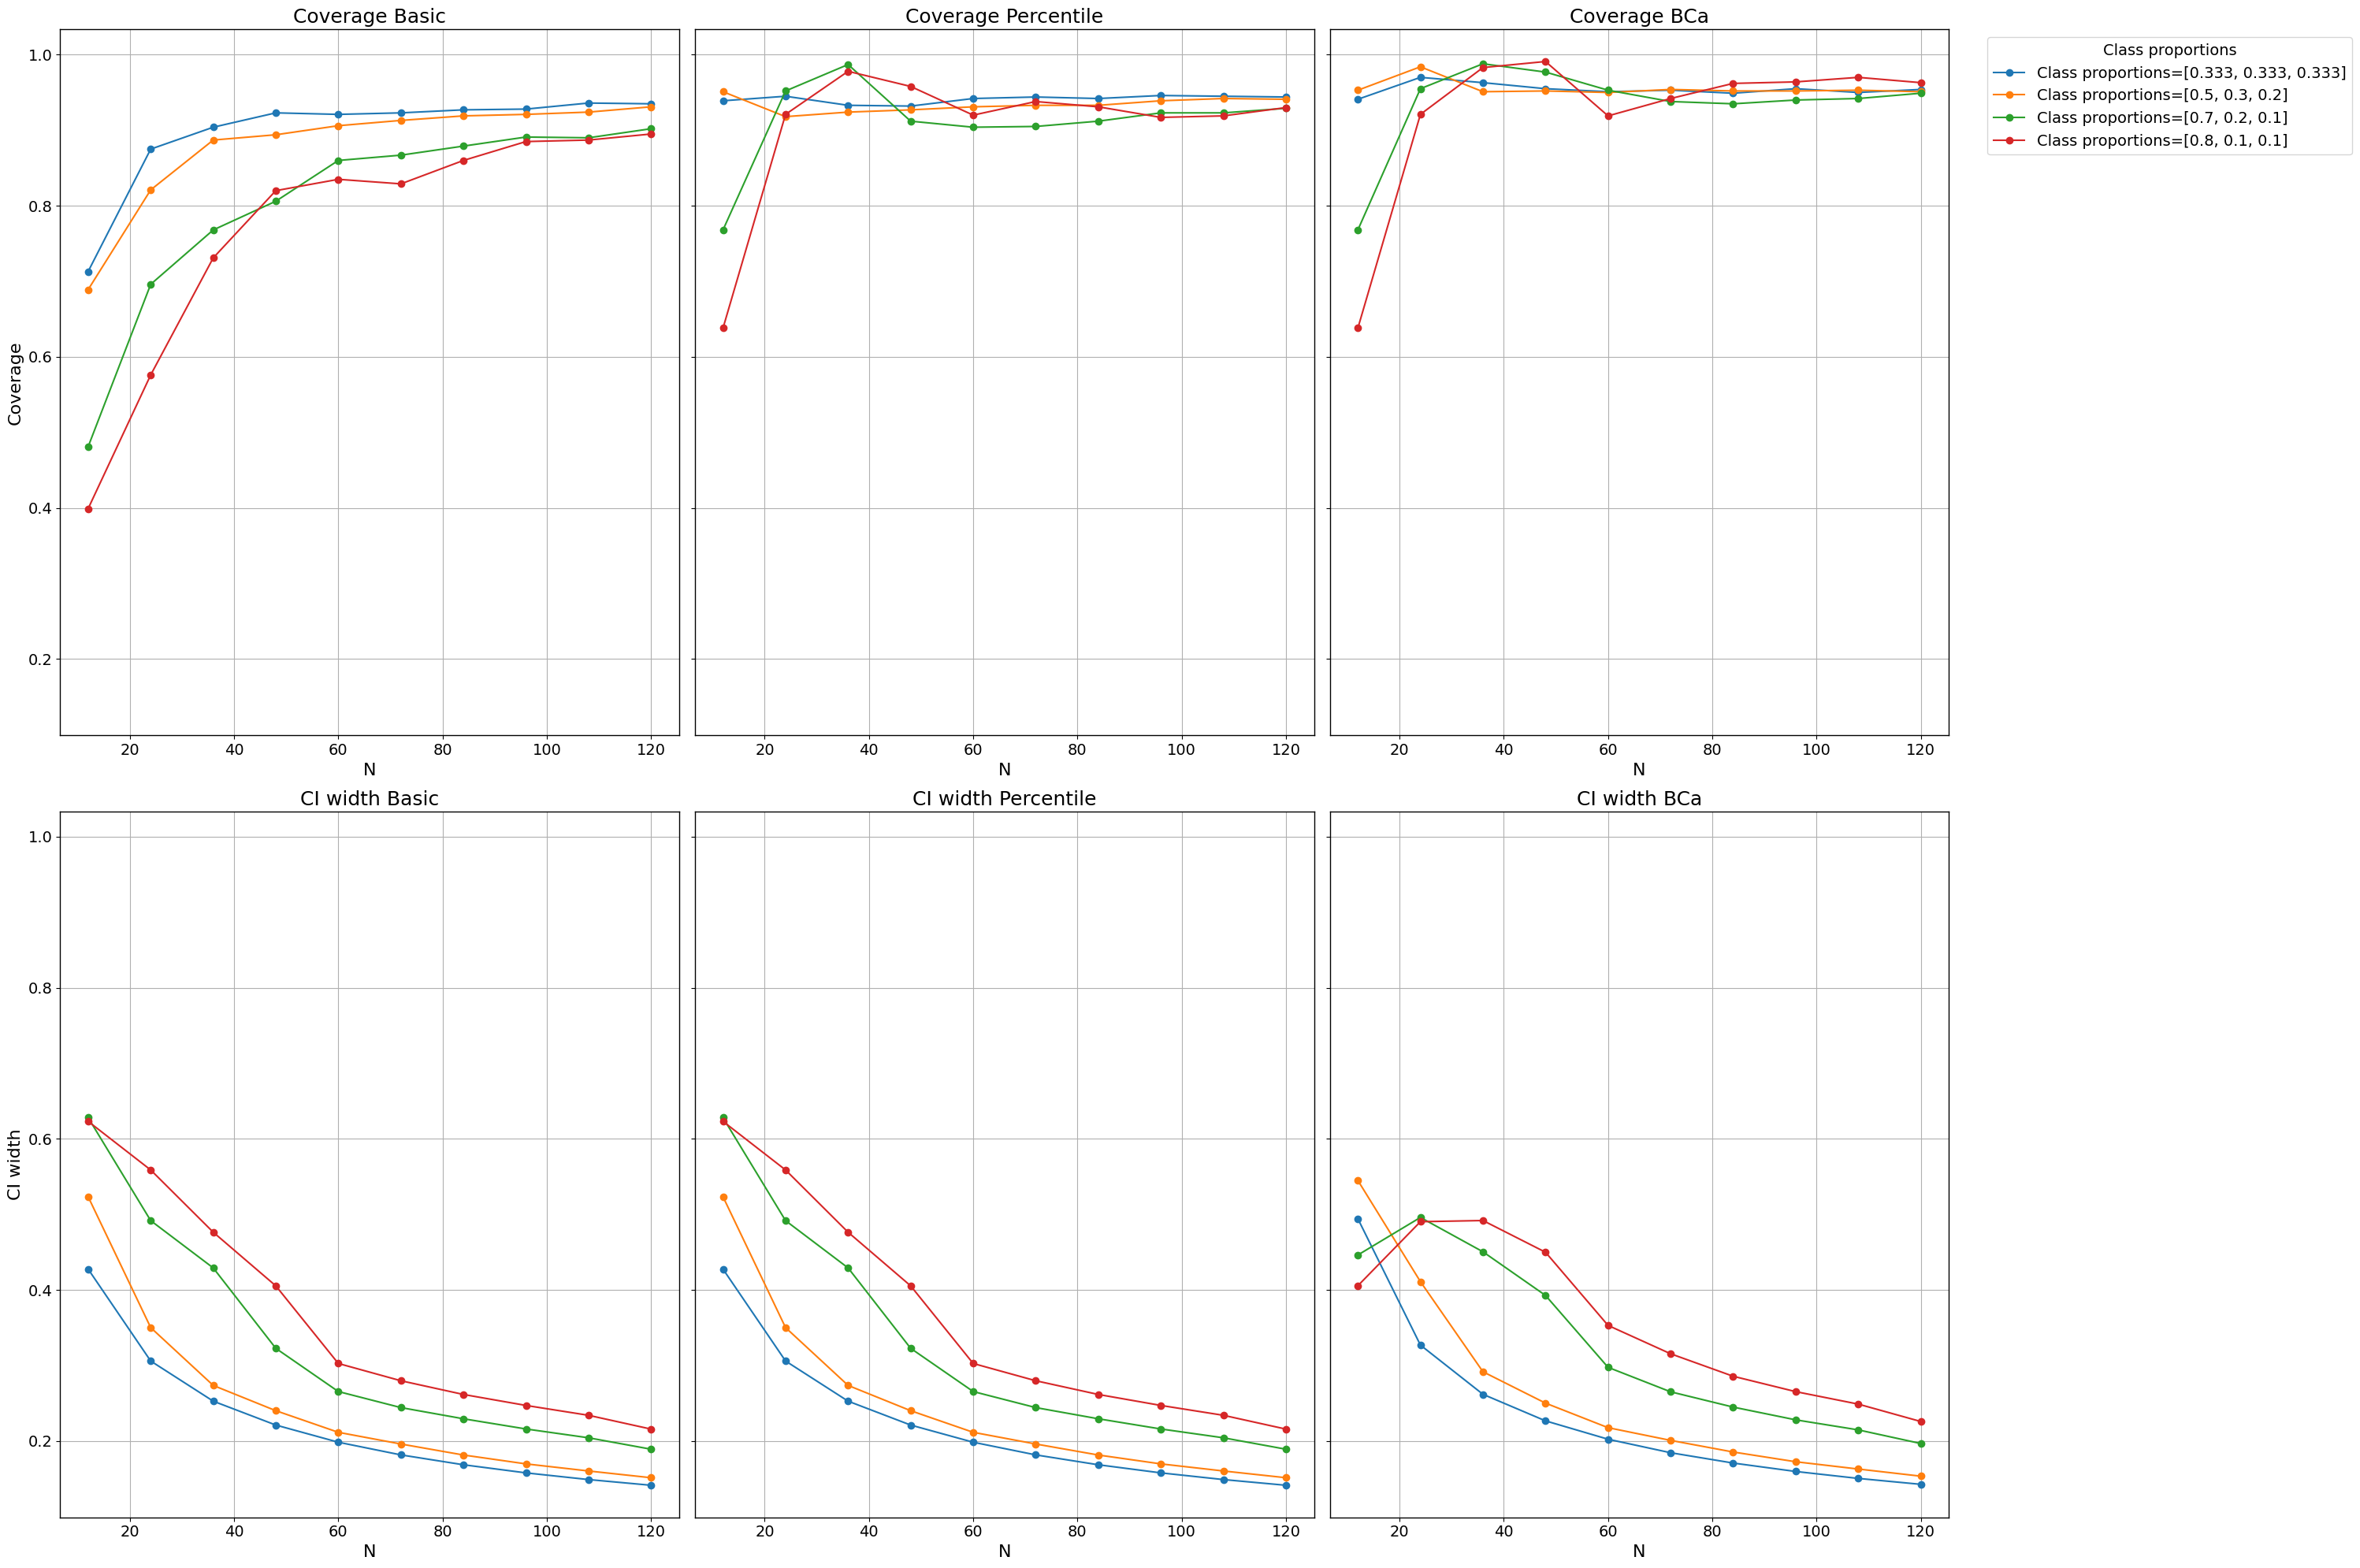

In [ ]:
fig, axes = plt.subplots(2, len(methods), figsize=(30, 20), sharey=True)

# Adjust font sizes
title_fontsize = 18
label_fontsize = 16
tick_fontsize = 14
legend_fontsize = 14

for ax, method in zip(axes[0], methods):
    for c_val, group in medians.groupby("imbalance"):
        ax.plot(group["N"], group[f"{method}_coverage"], marker="o", label=f"Class proportions={c_val}")
    ax.set_title(f"Coverage {method_labels[method]}", fontsize=title_fontsize)
    ax.set_xlabel("N", fontsize=label_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(True)

axes[0, 0].set_ylabel("Coverage", fontsize=label_fontsize)
axes[0, -1].legend(title="Class proportions", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=legend_fontsize, title_fontsize=legend_fontsize)

for ax, method in zip(axes[1], methods):
    for c_val, group in medians.groupby("imbalance"):
        ax.plot(group["N"], group[f"{method}_ci_width"], marker="o", label=f"Class proportions={c_val}")
    ax.set_title(f"CI width {method_labels[method]}", fontsize=title_fontsize)
    ax.set_xlabel("N", fontsize=label_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(True)

axes[1, 0].set_ylabel("CI width", fontsize=label_fontsize)

plt.tight_layout()
plt.savefig("../../../clean_figs/fig_10.pdf")
plt.show()

# Figure 11

In [ ]:
import numpy as np
import pandas as pd
from numba import njit, prange
from scipy.stats import norm

@njit
def balanced_accuracy_vec(y_true, y_pred, n_classes):
    """Vectorized balanced accuracy for a single sample."""
    recalls = np.zeros(n_classes, dtype=np.float32)
    for c in range(n_classes):
        mask = y_true == c
        n = mask.sum()
        if n > 0:
            recalls[c] = (y_pred[mask] == c).sum() / n
    return recalls.mean()

@njit(parallel=True)
def bootstrap_ba(y_true, y_pred, n_classes, n_bootstrap, random_state=None):
    """Compute balanced accuracy over bootstrap samples in parallel."""
    n_samples = y_true.shape[0]
    ba_boot = np.empty(n_bootstrap, dtype=np.float32)
    for b in prange(n_bootstrap):
        idx = np.random.randint(0, n_samples, n_samples)
        ba_boot[b] = balanced_accuracy_vec(y_true[idx], y_pred[idx], n_classes)
    return ba_boot

def stratified_bootstrap_CI_shared(y_true, y_pred, n_classes, n_bootstrap=1000, alpha=0.05):
    """
    Compute percentile, basic, and BCa bootstrap CIs using the same bootstrap samples.

    y_true, y_pred: shape (batch_size, n_samples)
    Returns:
        ci_lower_percentile, ci_upper_percentile,
        ci_lower_basic, ci_upper_basic,
        ci_lower_bca, ci_upper_bca
    """
    batch_size, n_samples = y_true.shape

    ci_lower_percentile = np.empty(batch_size, dtype=np.float32)
    ci_upper_percentile = np.empty(batch_size, dtype=np.float32)
    ci_lower_basic = np.empty(batch_size, dtype=np.float32)
    ci_upper_basic = np.empty(batch_size, dtype=np.float32)
    ci_lower_bca = np.empty(batch_size, dtype=np.float32)
    ci_upper_bca = np.empty(batch_size, dtype=np.float32)

    for i in range(batch_size):
        original_stat = balanced_accuracy_vec(y_true[i], y_pred[i], n_classes)

        # Bootstrap replicates
        ba_boot = bootstrap_ba(y_true[i], y_pred[i], n_classes, n_bootstrap)

        # Percentile CI
        ci_lower_percentile[i] = np.percentile(ba_boot, 100 * (alpha / 2))
        ci_upper_percentile[i] = np.percentile(ba_boot, 100 * (1 - alpha / 2))

        # Basic CI
        ci_lower_basic[i] = 2 * original_stat - ci_upper_percentile[i]
        ci_upper_basic[i] = 2 * original_stat - ci_lower_percentile[i]

        # ---- BCa CI ----
        # 1. Bias correction
        prop_less = (np.sum(ba_boot < original_stat)) / n_bootstrap
        # Avoid extreme values 0 or 1
        prop_less = np.clip(prop_less, 1e-10, 1 - 1e-10)
        z0 = norm.ppf(prop_less)

        # 2. Acceleration via jackknife
        jackknife_stats = []
        for j in range(n_samples):
            mask = np.ones(n_samples, dtype=bool)
            mask[j] = False
            jack_stat = balanced_accuracy_vec(y_true[i][mask], y_pred[i][mask], n_classes)
            jackknife_stats.append(jack_stat)
        jackknife_stats = np.array(jackknife_stats)
        jack_mean = np.mean(jackknife_stats)

        num = np.sum((jack_mean - jackknife_stats) ** 3)
        den = 6.0 * (np.sum((jack_mean - jackknife_stats) ** 2) ** 1.5)

        # Acceleration with guard
        acc = num / den if den > 0 else 0.0

        # 3. Adjusted quantiles with safeguard
        def safe_adj(z_alpha):
            denom = 1 - acc * (z0 + z_alpha)
            if np.isnan(denom) or np.isclose(denom, 0.0):
                # fall back to plain percentile quantile
                return norm.cdf(z_alpha)
            return norm.cdf(z0 + (z0 + z_alpha) / denom)

        z_alpha_low = norm.ppf(alpha / 2)
        z_alpha_high = norm.ppf(1 - alpha / 2)

        adj_low = np.clip(safe_adj(z_alpha_low), 0, 1)
        adj_high = np.clip(safe_adj(z_alpha_high), 0, 1)

        ci_lower_bca[i] = np.percentile(ba_boot, 100 * adj_low)
        ci_upper_bca[i] = np.percentile(ba_boot, 100 * adj_high)



    return (
        ci_lower_percentile,
        ci_upper_percentile,
        ci_lower_basic,
        ci_upper_basic,
        ci_lower_bca,
        ci_upper_bca,
    )


def coverage_of_ci(targets, predictions, C, true_val=0.8, alpha=0.05, B=1000):
    """
    Compute coverage for both percentile and basic CIs using shared bootstrap samples.
    """
    ci_perc_low, ci_perc_high, ci_basic_low, ci_basic_high, ci_bca_low, ci_bca_high = stratified_bootstrap_CI_shared(
        targets, predictions, C, n_bootstrap=B, alpha=alpha
    )
    
    results = {
        "N": targets.shape[1],
        "C": C,
        "percentile_coverage": np.mean((ci_perc_low <= true_val) & (ci_perc_high >= true_val)),
        "percentile_ci_width": np.mean(ci_perc_high - ci_perc_low),
        "basic_coverage": np.mean((ci_basic_low <= true_val) & (ci_basic_high >= true_val)),
        "basic_ci_width": np.mean(ci_basic_high - ci_basic_low),
        "bca_coverage": np.mean((ci_bca_low <= true_val) & (ci_bca_high >= true_val)),
        "bca_ci_width": np.mean(ci_bca_high - ci_bca_low)
    }
    
    return results

def make_synthetic_data(N, C, recalls_per_class, class_proportions=None, n_samples=1000):
    """
    Generate synthetic data with N samples, C classes, and specified recall per class.
    The number of correct predictions per class is sampled from a binomial distribution
    to allow variability in recall.
    """
    if class_proportions is None:
        n_per_class = np.full(C, N // C)
    else:
        class_proportions = np.sort(class_proportions)
        class_proportions /= class_proportions.sum()
        n_per_class = (class_proportions * N).astype(np.int32)
        # Adjust to ensure total is N
        n_per_class[-1] += N - n_per_class.sum()
    
    delimitations = np.concatenate(([0], np.cumsum(n_per_class)))
    # True labels
    y_true_row = np.empty(N, dtype=np.int32)
    for c in range(C):
        start, end = delimitations[c], delimitations[c+1]
        y_true_row[start:end] = c
    y_true = np.tile(y_true_row, (n_samples, 1))
    
    y_pred = np.empty((n_samples, N), dtype=np.int32)
    
    for i in range(n_samples):
        row_pred = np.empty(N, dtype=np.int32)
        for c in range(C):
            # indices of this class
            start, end = delimitations[c], delimitations[c+1]
            idx = np.arange(start, end)
            np.random.shuffle(idx)
            
            # number of correct predictions sampled from binomial
            n_correct = np.random.binomial(n_per_class[c], recalls_per_class[c])
            n_wrong = n_per_class[c] - n_correct
            
            # assign correct predictions
            row_pred[idx[:n_correct]] = c
            
            # assign wrong predictions
            if n_wrong > 0:
                wrong_choices = [x for x in range(C) if x != c]
                row_pred[idx[n_correct:]] = np.random.choice(wrong_choices, n_wrong)
        
        y_pred[i] = row_pred
    
    # Optionally shuffle columns to mix classes
    perm = np.array([np.random.permutation(N) for _ in range(n_samples)])
    y_true = y_true[np.arange(n_samples)[:, None], perm]
    y_pred = y_pred[np.arange(n_samples)[:, None], perm]
    
    return y_true, y_pred

def exp3_vary_recalls_runs(recall_per_class=[(0.8,0.8)], 
                        C=2,
                        N=250,
                        n_runs=15,
                        B=1000):
    """
    Run coverage experiment for multiple C and N values, with n_runs repetitions each.
    """
    results = []
    if np.isscalar(recall_per_class):
        rec = np.full(C, recall_per_class, dtype=np.float32)
    else:
        rec = np.asarray(recall_per_class, dtype=np.float32)
    
    for r in rec:
        for run in range(n_runs):
            print(f"Running recalls per class : {r}, run {run+1}/{n_runs}")
            # Generate synthetic data
            targets, predictions = make_synthetic_data(N, C, recalls_per_class=r)
            # Compute coverage using shared bootstrap
            cov_res = coverage_of_ci(targets, predictions, C, 
                                            true_val=np.mean(r), 
                                            alpha=0.05, 
                                            B=B)
            cov_res['run'] = run + 1
            cov_res['N'] = N
            cov_res["p1"] = r[0]
            cov_res["p2"] = r[1]
            results.append(cov_res)
    
    return pd.DataFrame(results)

# Values to sweep
base_vals = list(np.arange(0.5, 1.0, 0.05)) + [0.96, 0.97, 0.98, 0.99, 0.999]

# Case 1: diagonal p1 = p2
couples = [(p, p) for p in base_vals]

df_exp3 = exp3_vary_recalls_runs(couples, C=2, N=250, n_runs=15)

import matplotlib.pyplot as plt

# Compute median over runs
df_avg = df_exp3.groupby(["p1", "p2", "N"], as_index=False)[
    ["basic_coverage", "percentile_coverage", "bca_coverage",
     "basic_ci_width", "percentile_ci_width", "bca_ci_width"]
].median()

# ---- Case 1: Diagonal (p1 = p2) ----
df_diag = df_avg[df_avg["p1"] == df_avg["p2"]].groupby(["p1", "p2"], as_index=False).mean()

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Coverage
ax[0].plot(df_diag["p1"], df_diag["basic_coverage"], marker="o", color=method_colors["basic"], label="Basic")
ax[0].plot(df_diag["p1"], df_diag["percentile_coverage"], marker="o", color=method_colors["percentile"], label="Percentile")
ax[0].plot(df_diag["p1"], df_diag["bca_coverage"], marker="o", color=method_colors["bca"], label="BCa")
ax[0].set_title("Coverage - Diagonal (p1 = p2)")
ax[0].set_xlabel("p1 = p2")
ax[0].set_ylabel("Coverage")
ax[0].grid(True)
ax[0].legend()

# CI width
ax[1].plot(df_diag["p1"], df_diag["basic_ci_width"], marker="o", color=method_colors["basic"], label="Basic")
ax[1].plot(df_diag["p1"], df_diag["percentile_ci_width"], marker="o", color=method_colors["percentile"], label="Percentile")
ax[1].plot(df_diag["p1"], df_diag["bca_ci_width"], marker="o", color=method_colors["bca"], label="BCa")
ax[1].set_title("CI Width - Diagonal (p1 = p2)")
ax[1].set_xlabel("p1 = p2")
ax[1].set_ylabel("CI Width")
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.savefig("../../../clean_figs/fig_11.pdf")
plt.show()

Running recalls per class : [0.5 0.5], run 1/15
Running recalls per class : [0.5 0.5], run 2/15
Running recalls per class : [0.5 0.5], run 3/15
Running recalls per class : [0.5 0.5], run 4/15
Running recalls per class : [0.5 0.5], run 5/15


KeyboardInterrupt: 